<a href="https://colab.research.google.com/github/1EduardOrtega/TelecomX_parte2_Latam/blob/main/TelecomX_parte2_Latam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [225]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,precision_score,recall_score,f1_score
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
import pickle

# 1. Preparación de los Datos

Cargamos el archivo CSV con los datos que ya hemos tratado

In [245]:
url = "https://raw.githubusercontent.com/1EduardOrtega/TelecomX_parte2_Latam/refs/heads/main/datos_tratados.csv"

In [246]:
datos_tratados = pd.read_csv(url)

In [247]:
datos_tratados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Evasion                          7043 non-null   int64  
 1   Genero                           7043 non-null   object 
 2   AdultoMayor                      7043 non-null   int64  
 3   TienePareja                      7043 non-null   int64  
 4   TieneDependientes                7043 non-null   int64  
 5   MesesCliente                     7043 non-null   int64  
 6   SuscripcionTelefono              7043 non-null   int64  
 7   LineasMultiples                  7043 non-null   int64  
 8   SeguridadOnline                  7043 non-null   int64  
 9   RespaldoOnline                   7043 non-null   int64  
 10  ProteccionDispositivo            7043 non-null   int64  
 11  SoporteTecnico                   7043 non-null   int64  
 12  TVCable             

revisamos el contenido que ya hemos tratado para verificar si
los datos requieren algun tratamiento

In [248]:
datos_tratados.head()

Evasion  Genero  AdultoMayor  TienePareja  TieneDependientes  MesesCliente  \
0        0  Female            0            1                  1             9   
1        0    Male            0            0                  0             9   
2        1    Male            0            0                  0             4   
3        1    Male            1            1                  0            13   
4        1  Female            1            1                  0             3   

   SuscripcionTelefono  LineasMultiples  SeguridadOnline  RespaldoOnline  ...  \
0                    1                0                0               1  ...   
1                    1                1                0               0  ...   
2                    1                0                0               0  ...   
3                    1                0                0               1  ...   
4                    1                0                0               0  ...   

   CargoMensual  CargoTotal  Internet_Fibra  SinInternet  Contrato_1Año  \
0          65.6      593.30               0            0              1   
1          59.9      542.40               0            0              0   
2          73.9      280.85               1            0              0   
3          98.0     1237.85               1            0              0   
4          83.9      267.40               1            0              0   

   Contrato_2Años  Pago_TarjetaCredito(automatico)  Pago_ChequeElectronico  \
0               0                                0                       0   
1               0                                0                       0   
2               0                                0                       1   
3               0                                0                       1   
4               0                                0                       0   

   Pago_ChequeFisico  Cuentas_Diarias  
0                  1         2.186667  
1                  1         1.996667  
2                  0         2.463333  
3                  0         3.266667  
4                  1         2.796667  

[5 rows x 25 columns]

**Creamos un Heatmap para revisar si existe multicolinealidad y poder determinar si hay columnas que debemos eliminar**

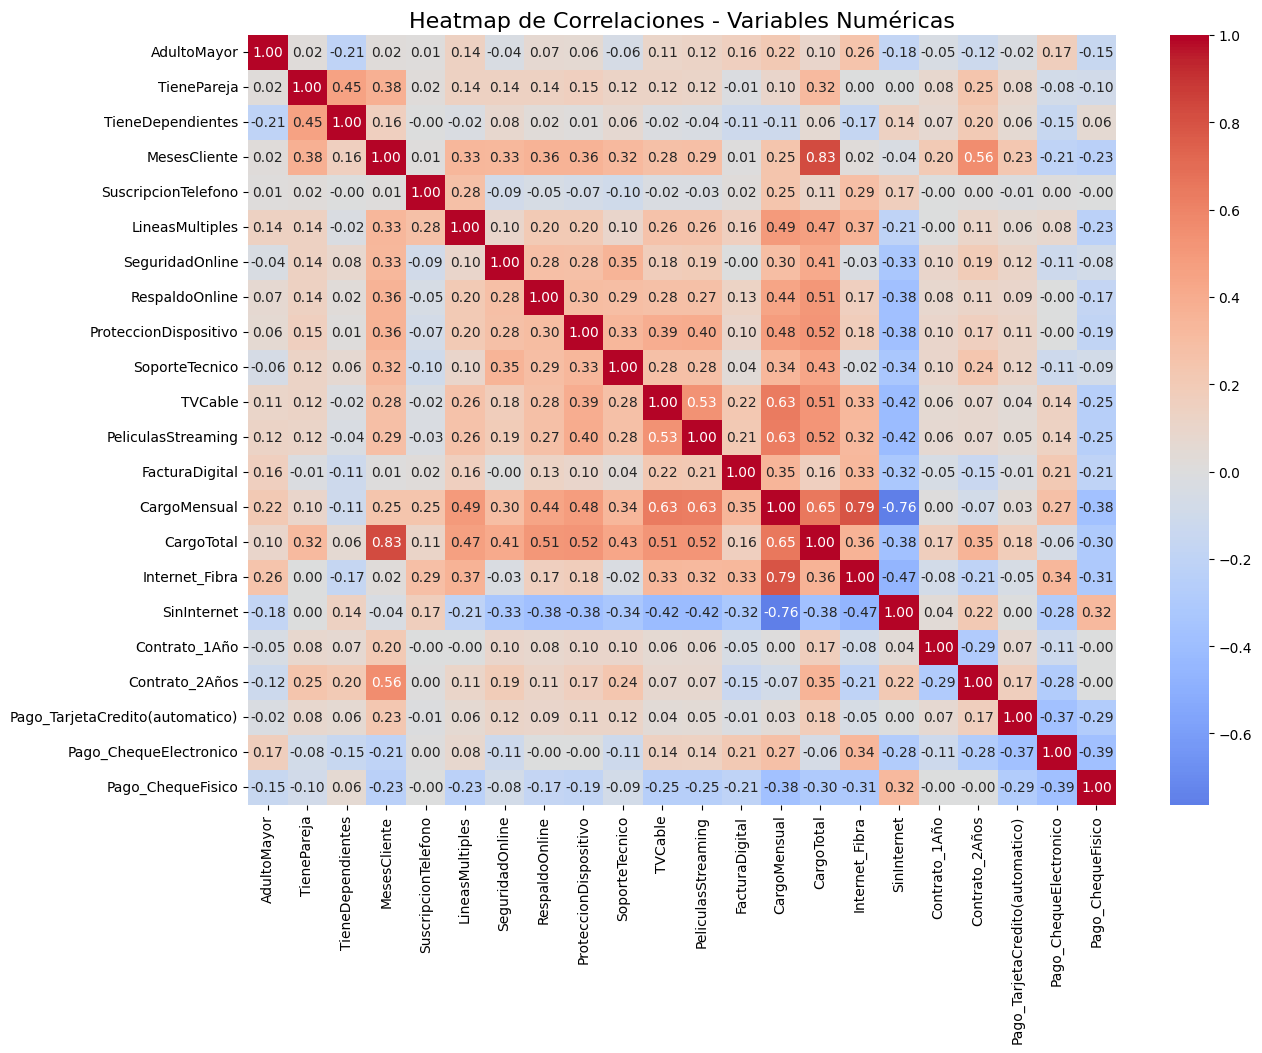

                           Variable         VIF
13                     CargoMensual  203.640917
4               SuscripcionTelefono   46.539912
14                       CargoTotal   21.299863
3                      MesesCliente   20.268478
15                   Internet_Fibra   17.193304
16                      SinInternet    8.035317
11               PeliculasStreaming    5.007206
10                          TVCable    4.864322
18                   Contrato_2Años    3.465791
8             ProteccionDispositivo    2.981145
12                   FacturaDigital    2.954409
20           Pago_ChequeElectronico    2.952989
7                    RespaldoOnline    2.888090
5                   LineasMultiples    2.838304
1                       TienePareja    2.827053
9                    SoporteTecnico    2.745797
6                   SeguridadOnline    2.666213
21                Pago_ChequeFisico    2.389126
17                    Contrato_1Año    2.050962
19  Pago_TarjetaCredito(automatico)    1

In [253]:

df_numericas = datos_tratados.drop(columns=["Genero"])
df_numericas = df_numericas.select_dtypes(include=['int64', 'float64']).drop(columns=["Evasion"])


plt.figure(figsize=(14,10))
sns.heatmap(df_numericas.corr(), annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Heatmap de Correlaciones - Variables Numéricas", fontsize=16)
plt.show()


vif_data = pd.DataFrame()
vif_data["Variable"] = df_numericas.columns
vif_data["VIF"] = [variance_inflation_factor(df_numericas.values, i)
                   for i in range(len(df_numericas.columns))]

vif_data = vif_data.sort_values(by="VIF", ascending=False)

print(vif_data)


**Visualizamos nuevamente el Heatmap resaltando unicamente aquellas variables que se pueden indicar  multicolinealidad y poder determinar si hay que eliminarlas**

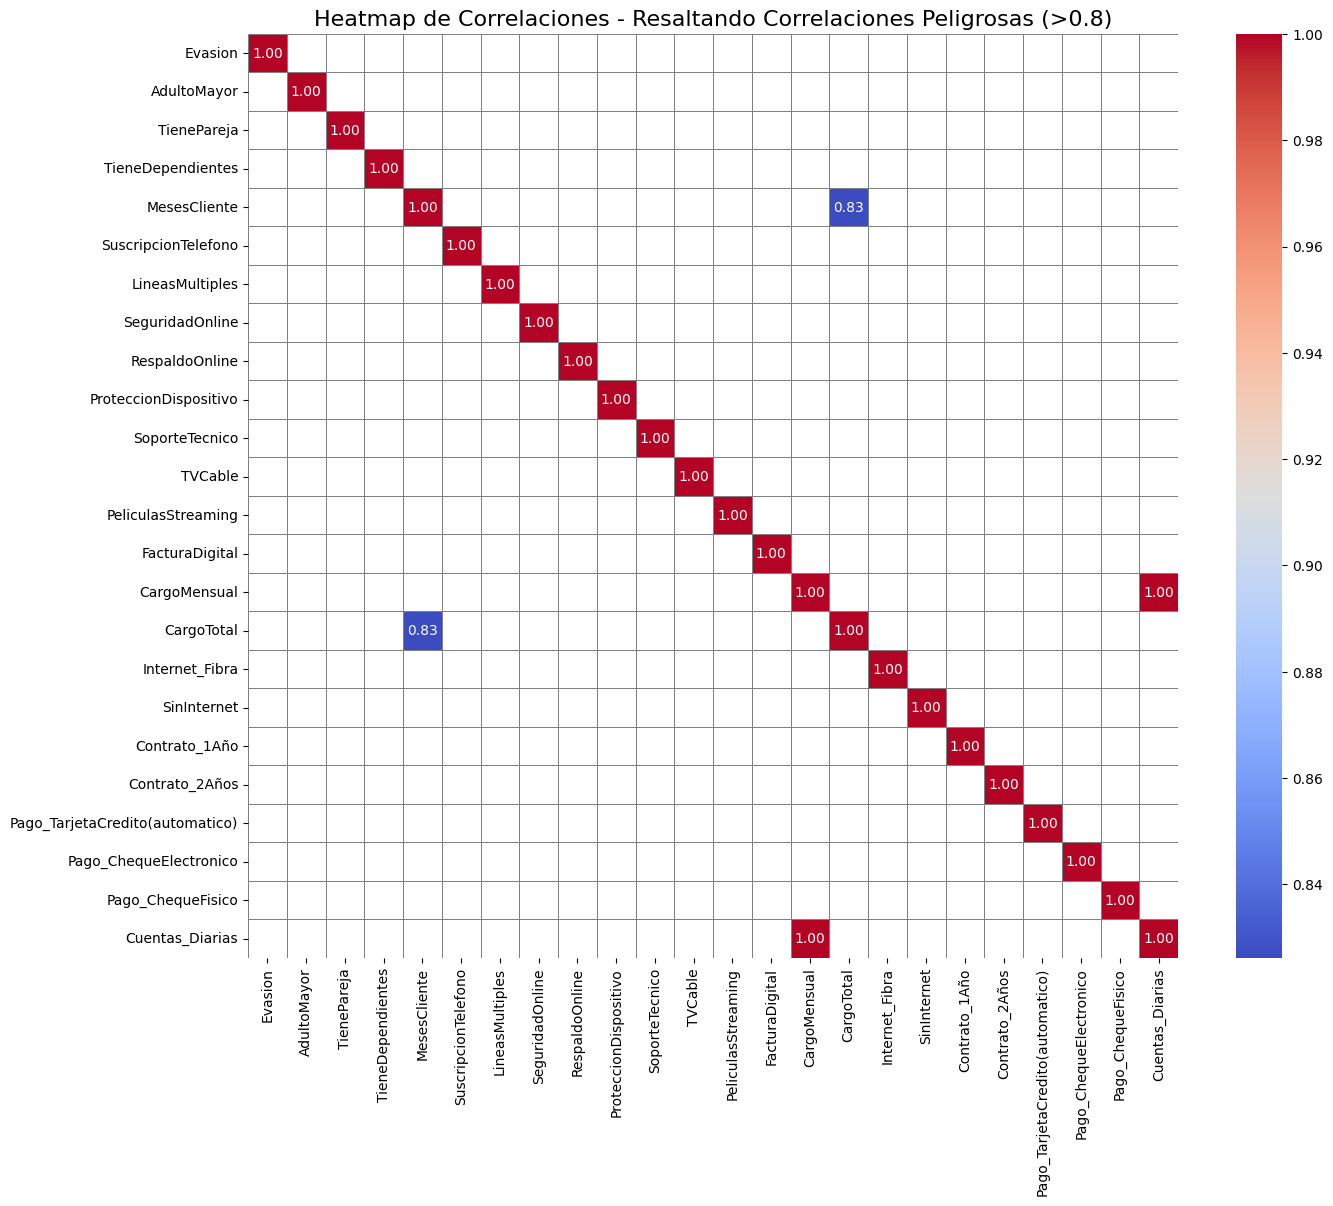

In [251]:
corr = datos_tratados.select_dtypes(include=[np.number]).corr()
mask = np.abs(corr) < 0.8

plt.figure(figsize=(15, 12))
sns.heatmap(corr,
            annot=True,
            fmt=".2f",
            cmap="coolwarm",
            mask=mask,
            cbar=True,
            linewidths=0.5,
            linecolor='gray')
plt.title("Heatmap de Correlaciones - Resaltando Correlaciones Peligrosas (>0.8)", fontsize=16)
plt.show()


**En base a lo que anterior decidimos eliminar la columna Cuentas_Diarias**

In [252]:

datos_tratados = datos_tratados.drop(columns=['Cuentas_Diarias'])

datos_tratados.head()


Evasion  Genero  AdultoMayor  TienePareja  TieneDependientes  MesesCliente  \
0        0  Female            0            1                  1             9   
1        0    Male            0            0                  0             9   
2        1    Male            0            0                  0             4   
3        1    Male            1            1                  0            13   
4        1  Female            1            1                  0             3   

   SuscripcionTelefono  LineasMultiples  SeguridadOnline  RespaldoOnline  ...  \
0                    1                0                0               1  ...   
1                    1                1                0               0  ...   
2                    1                0                0               0  ...   
3                    1                0                0               1  ...   
4                    1                0                0               0  ...   

   FacturaDigital  CargoMensual  CargoTotal  Internet_Fibra  SinInternet  \
0               1          65.6      593.30               0            0   
1               0          59.9      542.40               0            0   
2               1          73.9      280.85               1            0   
3               1          98.0     1237.85               1            0   
4               1          83.9      267.40               1            0   

   Contrato_1Año  Contrato_2Años  Pago_TarjetaCredito(automatico)  \
0              1               0                                0   
1              0               0                                0   
2              0               0                                0   
3              0               0                                0   
4              0               0                                0   

   Pago_ChequeElectronico  Pago_ChequeFisico  
0                       0                  1  
1                       0                  1  
2                       1                  0  
3                       1                  0  
4                       0                  1  

[5 rows x 24 columns]

Continuamos con el analisis de los datos, ahora aplicamos one-hot encoding a la columna de Genero

In [233]:
datos_tratados = pd.get_dummies(datos_tratados, columns=['Genero'], drop_first=True)
datos_tratados = datos_tratados.astype({col: 'int64' for col in datos_tratados.select_dtypes('bool').columns})

datos_tratados.head()


Evasion  AdultoMayor  TienePareja  TieneDependientes  MesesCliente  \
0        0            0            1                  1             9   
1        0            0            0                  0             9   
2        1            0            0                  0             4   
3        1            1            1                  0            13   
4        1            1            1                  0             3   

   SuscripcionTelefono  LineasMultiples  SeguridadOnline  RespaldoOnline  \
0                    1                0                0               1   
1                    1                1                0               0   
2                    1                0                0               0   
3                    1                0                0               1   
4                    1                0                0               0   

   ProteccionDispositivo  ...  CargoMensual  CargoTotal  Internet_Fibra  \
0                      0  ...          65.6      593.30               0   
1                      0  ...          59.9      542.40               0   
2                      1  ...          73.9      280.85               1   
3                      1  ...          98.0     1237.85               1   
4                      0  ...          83.9      267.40               1   

   SinInternet  Contrato_1Año  Contrato_2Años  \
0            0              1               0   
1            0              0               0   
2            0              0               0   
3            0              0               0   
4            0              0               0   

   Pago_TarjetaCredito(automatico)  Pago_ChequeElectronico  Pago_ChequeFisico  \
0                                0                       0                  1   
1                                0                       0                  1   
2                                0                       1                  0   
3                                0                       1                  0   
4                                0                       0                  1   

   Genero_Male  
0            0  
1            1  
2            1  
3            1  
4            0  

[5 rows x 24 columns]

# 2. Correlación y Selección de Variables

**Teniendo los datos listo, procedemos a revisar la proporcion de clientes que cancelaron y no cancelaron**

In [234]:
conteo = datos_tratados['Evasion'].value_counts()
proporcion = datos_tratados['Evasion'].value_counts(normalize=True) * 100

tabla_balance = pd.DataFrame({
    'Cantidad': conteo,
    'Proporción (%)': proporcion
})

print(tabla_balance)


         Cantidad  Proporción (%)
Evasion                          
0            5174       73.463013
1            1869       26.536987


**Graficamos para poder tener una mejor visualizacion de las proporciones**

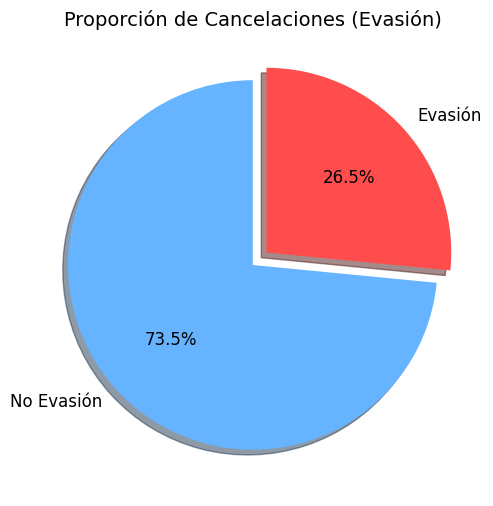

In [235]:
counts = datos_tratados['Evasion'].value_counts()
labels = ['No Evasión', 'Evasión']
colors = ['#66b3ff', '#ff4d4d']
explode = (0, 0.1)

plt.figure(figsize=(6,6))
plt.pie(counts, labels=labels, colors=colors, autopct='%1.1f%%',
        startangle=90, explode=explode, shadow=True, textprops={'fontsize': 12})
plt.title('Proporción de Cancelaciones (Evasión)', fontsize=14)
plt.show()


**En base al analisis anterior puede notarse que existe un desbalanceo entre las clases, por lo que se aplicaremos un oversampling en la clase minoritaria,
con esto buscamos lograr un equilibrio**

In [236]:
X = datos_tratados.drop(columns=['Evasion'])
y = datos_tratados['Evasion']

smote = SMOTE(random_state=42)

X_res, y_res = smote.fit_resample(X, y)

datos_balanceados = pd.DataFrame(X_res, columns=X.columns)
datos_balanceados['Evasion'] = y_res

print(y_res.value_counts(normalize=True) * 100)


Evasion
0    50.0
1    50.0
Name: proportion, dtype: float64


In [237]:
numericas = datos_balanceados.select_dtypes(include=['int64', 'float64'])

numericas.describe().T


count         mean          std    min  \
AdultoMayor                      10348.0     0.135388     0.342155   0.00   
TienePareja                      10348.0     0.379010     0.485164   0.00   
TieneDependientes                10348.0     0.217627     0.412652   0.00   
MesesCliente                     10348.0    27.655102    23.987864   0.00   
SuscripcionTelefono              10348.0     0.897082     0.303867   0.00   
LineasMultiples                  10348.0     0.384905     0.486596   0.00   
SeguridadOnline                  10348.0     0.207673     0.405661   0.00   
RespaldoOnline                   10348.0     0.276382     0.447230   0.00   
ProteccionDispositivo            10348.0     0.273579     0.445817   0.00   
SoporteTecnico                   10348.0     0.210572     0.407735   0.00   
TVCable                          10348.0     0.357750     0.479361   0.00   
PeliculasStreaming               10348.0     0.360649     0.480212   0.00   
FacturaDigital                   10348.0     0.597120     0.490501   0.00   
CargoMensual                     10348.0    68.033619    28.716511  18.25   
CargoTotal                       10348.0  2046.822222  2187.059386   0.00   
Internet_Fibra                   10348.0     0.511307     0.499896   0.00   
SinInternet                      10348.0     0.161867     0.368347   0.00   
Contrato_1Año                    10348.0     0.149208     0.356310   0.00   
Contrato_2Años                   10348.0     0.165056     0.371249   0.00   
Pago_TarjetaCredito(automatico)  10348.0     0.152880     0.359889   0.00   
Pago_ChequeElectronico           10348.0     0.350889     0.477271   0.00   
Pago_ChequeFisico                10348.0     0.177232     0.381884   0.00   
Genero_Male                      10348.0     0.431098     0.495254   0.00   
Evasion                          10348.0     0.500000     0.500024   0.00   

                                        25%          50%          75%      max  
AdultoMayor                        0.000000     0.000000     0.000000     1.00  
TienePareja                        0.000000     0.000000     1.000000     1.00  
TieneDependientes                  0.000000     0.000000     0.000000     1.00  
MesesCliente                       5.000000    21.000000    49.000000    72.00  
SuscripcionTelefono                1.000000     1.000000     1.000000     1.00  
LineasMultiples                    0.000000     0.000000     1.000000     1.00  
SeguridadOnline                    0.000000     0.000000     0.000000     1.00  
RespaldoOnline                     0.000000     0.000000     1.000000     1.00  
ProteccionDispositivo              0.000000     0.000000     1.000000     1.00  
SoporteTecnico                     0.000000     0.000000     0.000000     1.00  
TVCable                            0.000000     0.000000     1.000000     1.00  
PeliculasStreaming                 0.000000     0.000000     1.000000     1.00  
FacturaDigital                     0.000000     1.000000     1.000000     1.00  
CargoMensual                      45.680695    74.750000    91.052339   118.75  
CargoTotal                       270.485480  1170.650731  3264.579644  8684.80  
Internet_Fibra                     0.000000     1.000000     1.000000     1.00  
SinInternet                        0.000000     0.000000     0.000000     1.00  
Contrato_1Año                      0.000000     0.000000     0.000000     1.00  
Contrato_2Años                     0.000000     0.000000     0.000000     1.00  
Pago_TarjetaCredito(automatico)    0.000000     0.000000     0.000000     1.00  
Pago_ChequeElectronico             0.000000     0.000000     1.000000     1.00  
Pago_ChequeFisico                  0.000000     0.000000     0.000000     1.00  
Genero_Male                        0.000000     0.000000     1.000000     1.00  
Evasion                            0.000000     0.500000     1.000000     1.00

**Visualizamos la matriz de correlación para identificar relaciones entre las variables numéricas.**

Correlaciones con Evasion:
Evasion                            1.000000
Internet_Fibra                     0.327297
CargoMensual                       0.235712
Pago_ChequeElectronico             0.211195
FacturaDigital                     0.125506
AdultoMayor                        0.019489
SuscripcionTelefono               -0.013040
TVCable                           -0.016935
PeliculasStreaming                -0.019320
LineasMultiples                   -0.051439
Genero_Male                       -0.153962
Pago_ChequeFisico                 -0.195873
ProteccionDispositivo             -0.200083
RespaldoOnline                    -0.205717
CargoTotal                        -0.230041
Pago_TarjetaCredito(automatico)   -0.267995
Contrato_1Año                     -0.290215
SinInternet                       -0.301984
SoporteTecnico                    -0.305520
TienePareja                       -0.307555
TieneDependientes                 -0.308203
SeguridadOnline                   -0.309464
Contr

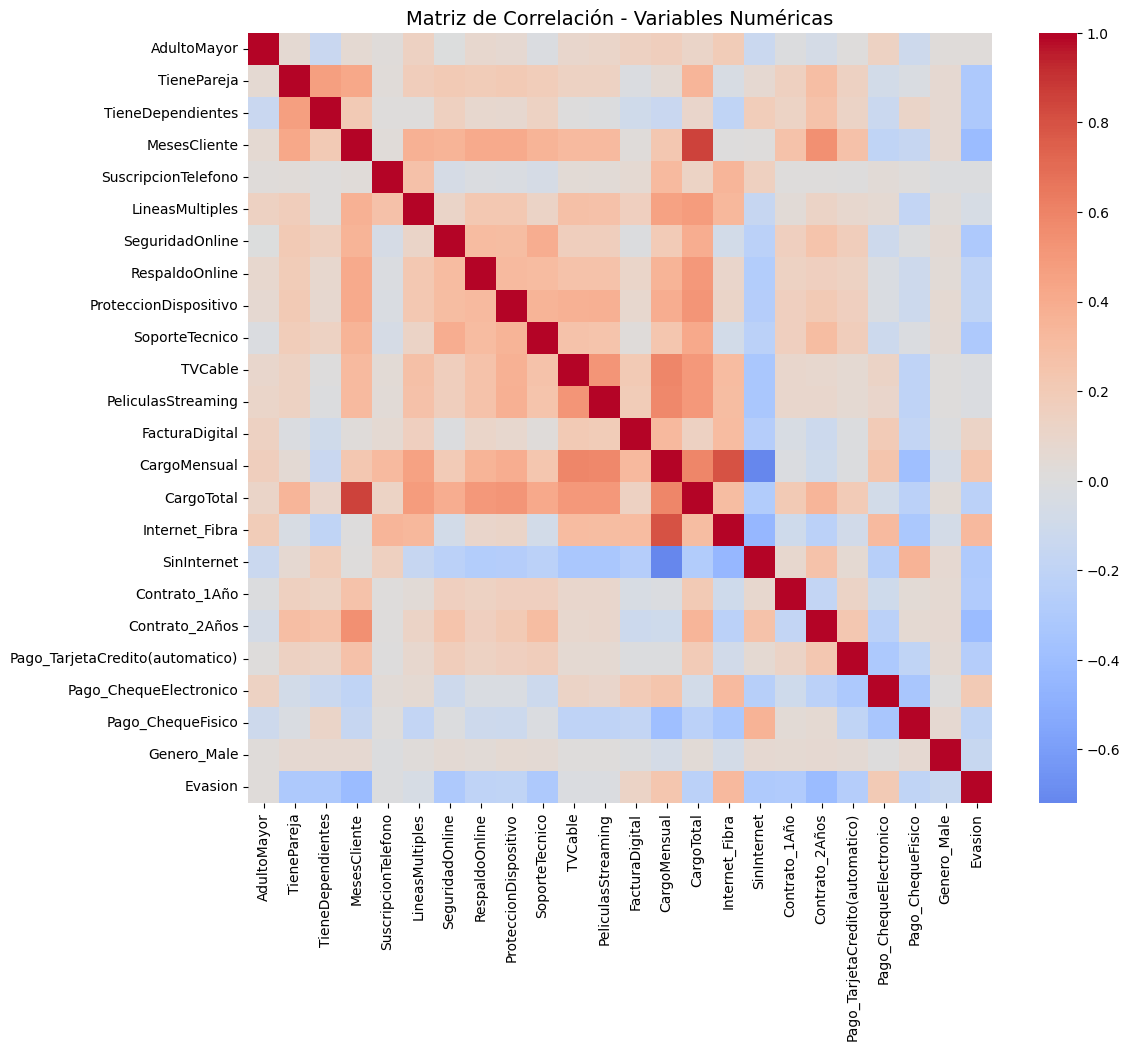

/tmp/ipython-input-2085989344.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_evasion.values, y=corr_evasion.index, palette="coolwarm")


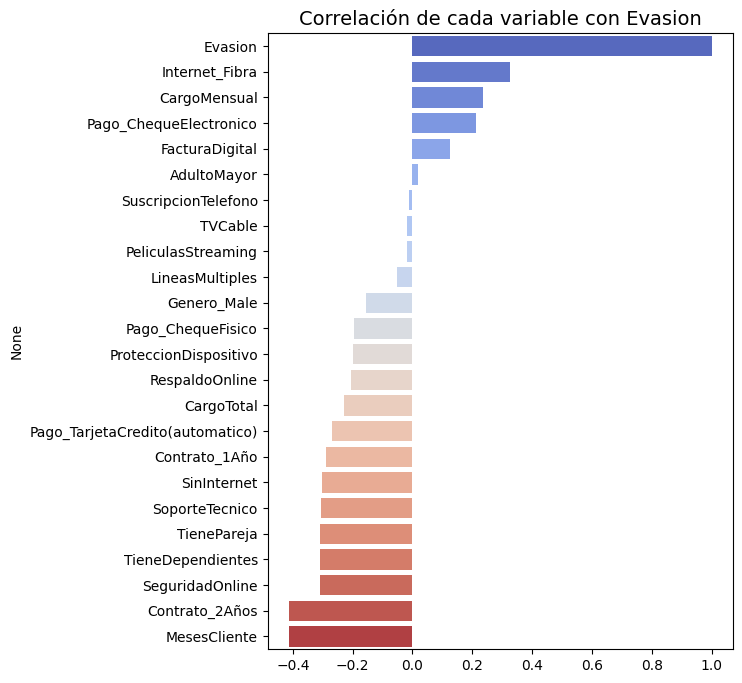

In [238]:
corr_matrix = datos_balanceados.corr()
corr_evasion = corr_matrix["Evasion"].sort_values(ascending=False)

print("Correlaciones con Evasion:")
print(corr_evasion)

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, annot=False)
plt.title("Matriz de Correlación - Variables Numéricas", fontsize=14)
plt.show()

plt.figure(figsize=(6, 8))
sns.barplot(x=corr_evasion.values, y=corr_evasion.index, palette="coolwarm")
plt.title("Correlación de cada variable con Evasion", fontsize=14)
plt.show()


**En base a los datos obtenidos en el análisis anterior procedemos a visualizar como las variables se relacionan con la cancelación**

/tmp/ipython-input-1775410701.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Evasion', y='MesesCliente', data=datos_balanceados, palette='Set2')


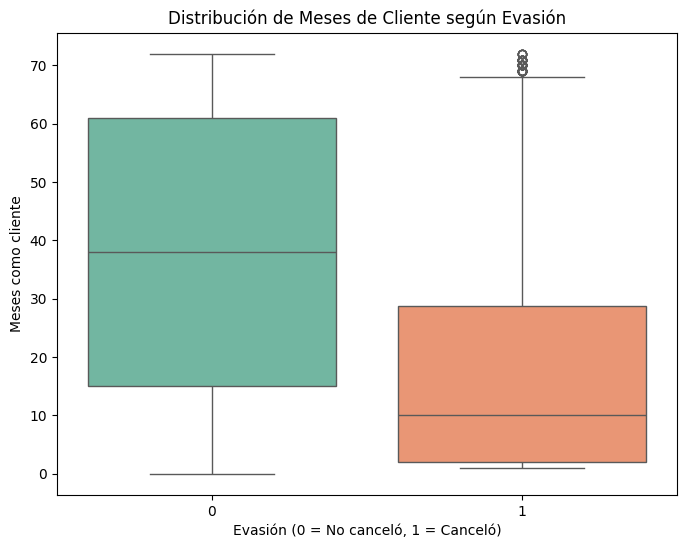

In [239]:

plt.figure(figsize=(8,6))
sns.boxplot(x='Evasion', y='MesesCliente', data=datos_balanceados, palette='Set2')
plt.title('Distribución de Meses de Cliente según Evasión')
plt.xlabel('Evasión (0 = No canceló, 1 = Canceló)')
plt.ylabel('Meses como cliente')
plt.show()



/tmp/ipython-input-1031148138.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Contrato_1Año', y='Evasion', data=datos_balanceados, estimator=lambda x: 100 * sum(x) / len(x), ax=axes[0], palette='Set2')
/tmp/ipython-input-1031148138.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Contrato_2Años', y='Evasion', data=datos_balanceados, estimator=lambda x: 100 * sum(x) / len(x), ax=axes[1], palette='Set2')


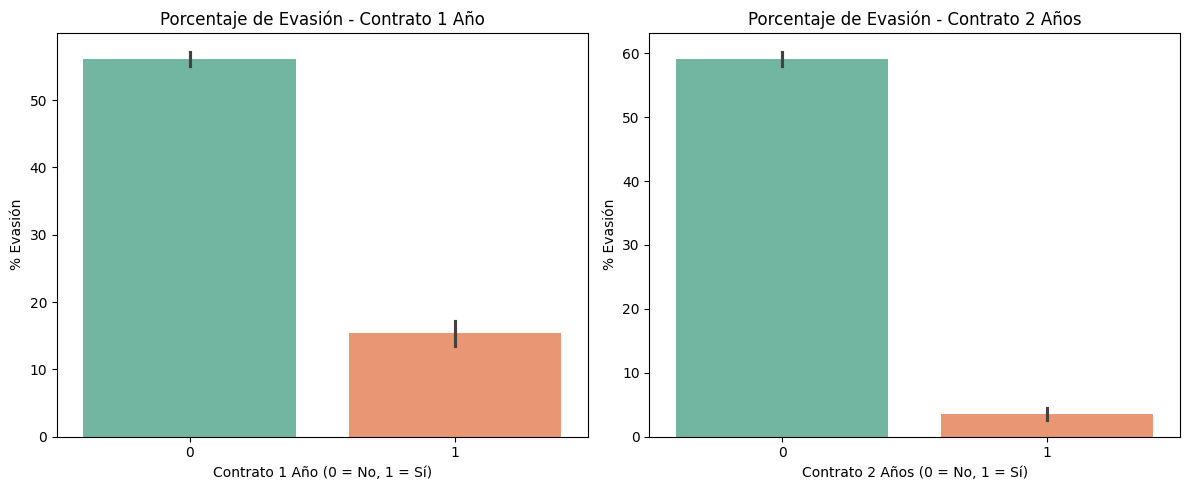

In [192]:

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Contrato 1 Año
sns.barplot(x='Contrato_1Año', y='Evasion', data=datos_balanceados, estimator=lambda x: 100 * sum(x) / len(x), ax=axes[0], palette='Set2')
axes[0].set_title('Porcentaje de Evasión - Contrato 1 Año')
axes[0].set_ylabel('% Evasión')
axes[0].set_xlabel('Contrato 1 Año (0 = No, 1 = Sí)')

# Contrato 2 Años
sns.barplot(x='Contrato_2Años', y='Evasion', data=datos_balanceados, estimator=lambda x: 100 * sum(x) / len(x), ax=axes[1], palette='Set2')
axes[1].set_title('Porcentaje de Evasión - Contrato 2 Años')
axes[1].set_ylabel('% Evasión')
axes[1].set_xlabel('Contrato 2 Años (0 = No, 1 = Sí)')

plt.tight_layout()
plt.show()


/tmp/ipython-input-804218370.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Internet_Fibra', y='Evasion',
/tmp/ipython-input-804218370.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Pago_ChequeElectronico', y='Evasion',
/tmp/ipython-input-804218370.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Evasion', y='CargoMensual',


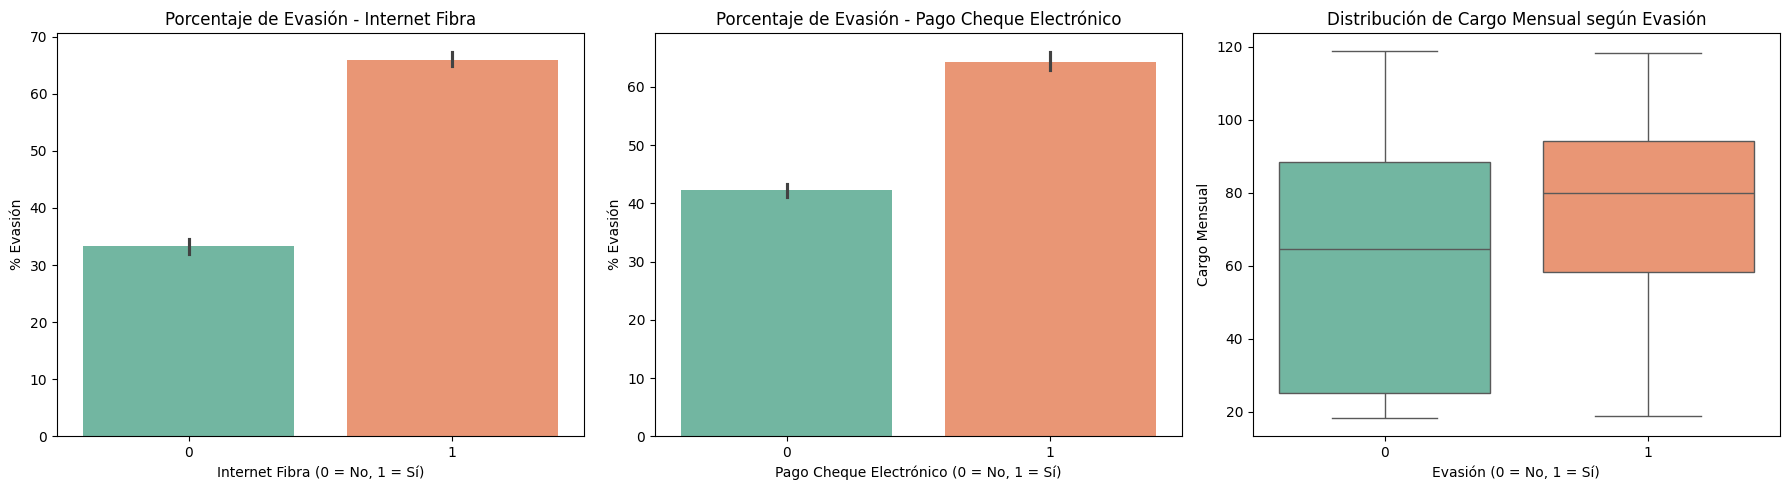

In [193]:

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Internet_Fibra
sns.barplot(x='Internet_Fibra', y='Evasion',
            data=datos_balanceados,
            estimator=lambda x: 100 * sum(x) / len(x),
            ax=axes[0], palette='Set2')
axes[0].set_title('Porcentaje de Evasión - Internet Fibra')
axes[0].set_ylabel('% Evasión')
axes[0].set_xlabel('Internet Fibra (0 = No, 1 = Sí)')

# Pago_ChequeElectronico
sns.barplot(x='Pago_ChequeElectronico', y='Evasion',
            data=datos_balanceados,
            estimator=lambda x: 100 * sum(x) / len(x),
            ax=axes[1], palette='Set2')
axes[1].set_title('Porcentaje de Evasión - Pago Cheque Electrónico')
axes[1].set_ylabel('% Evasión')
axes[1].set_xlabel('Pago Cheque Electrónico (0 = No, 1 = Sí)')

# CargoMensual
sns.boxplot(x='Evasion', y='CargoMensual',
            data=datos_balanceados,
            palette='Set2', ax=axes[2])
axes[2].set_title('Distribución de Cargo Mensual según Evasión')
axes[2].set_xlabel('Evasión (0 = No, 1 = Sí)')
axes[2].set_ylabel('Cargo Mensual')

plt.tight_layout()
plt.show()


/tmp/ipython-input-2902024164.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-2902024164.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-2902024164.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-2902024164.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-2902024164.py:20: FutureWarning: 

Passing `

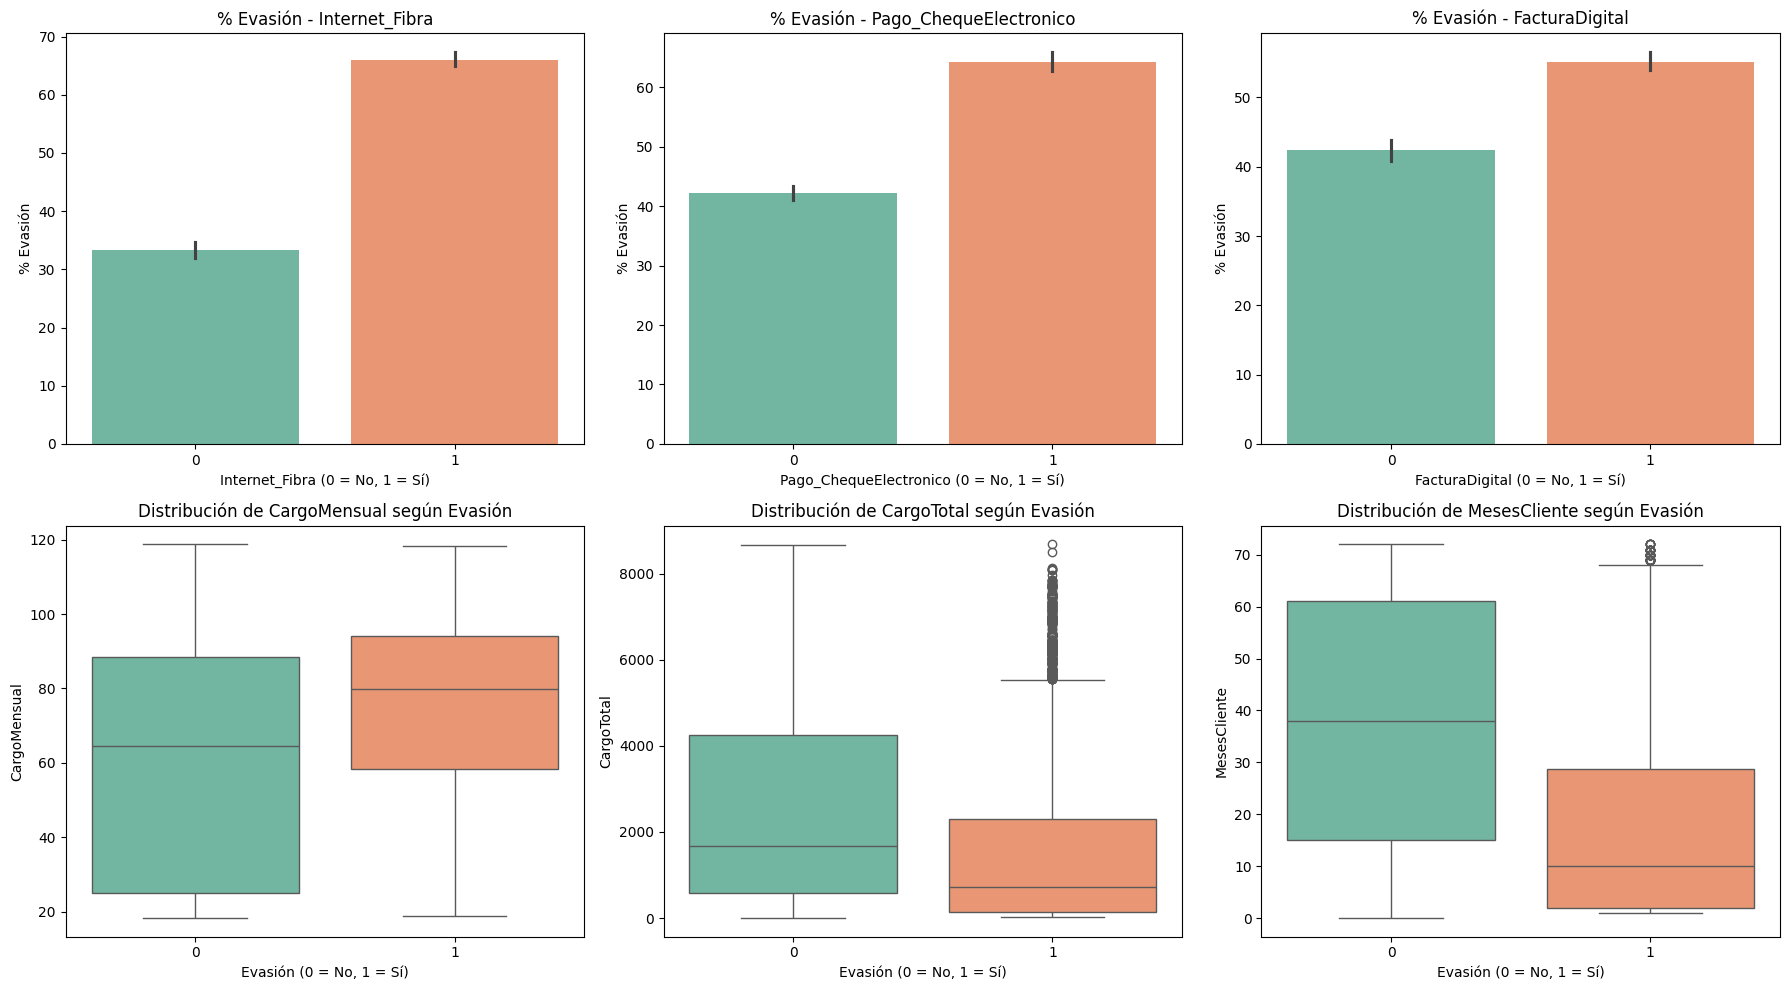

In [194]:

vars_binarias = ['Internet_Fibra', 'Pago_ChequeElectronico', 'FacturaDigital']
vars_continuas = ['CargoMensual', 'CargoTotal', 'MesesCliente']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for i, var in enumerate(vars_binarias):
    sns.barplot(
        x=var,
        y='Evasion',
        data=datos_balanceados,
        estimator=lambda x: 100 * sum(x) / len(x),
        palette='Set2',
        ax=axes[0, i]
    )
    axes[0, i].set_title(f'% Evasión - {var}')
    axes[0, i].set_ylabel('% Evasión')
    axes[0, i].set_xlabel(var + " (0 = No, 1 = Sí)")

for i, var in enumerate(vars_continuas):
    sns.boxplot(
        x='Evasion',
        y=var,
        data=datos_balanceados,
        palette='Set2',
        ax=axes[1, i]
    )
    axes[1, i].set_title(f'Distribución de {var} según Evasión')
    axes[1, i].set_xlabel('Evasión (0 = No, 1 = Sí)')
    axes[1, i].set_ylabel(var)

plt.tight_layout()
plt.show()


# 3. Modelado Predictivo

**Procedemos a dividir el conjunto de datos en entrenamiento y prueba para evaluar el rendimiento del modelo, decidimos aplicar una división de 70% para entrenamiento y 30% para prueba**

In [195]:
X = datos_balanceados.drop('Evasion', axis=1)
y = datos_balanceados['Evasion']

# Dividimos en entrenamiento y prueba70/30
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print(f"Tamaño de entrenamiento: {X_train.shape[0]} filas")
print(f"Tamaño de prueba: {X_test.shape[0]} filas")


Tamaño de entrenamiento: 7243 filas
Tamaño de prueba: 3105 filas


## Árbol de Decisión

**Teniendo ya nuestro conjunto de datos de entrenamiento y prueba iniciamos creando un modelo de Árbol de decisión.**

In [196]:
modelo_arbol = DecisionTreeClassifier(
    criterion='gini',
    max_depth=4,     # profundidad de 4
    random_state=42
)
modelo_arbol.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

In [197]:
modelo_arbol.score(X_train, y_train)

0.788485434212343

**Procedemos a evaluar el modelo**

Matriz de Confusión:
[[1095  458]
 [ 235 1317]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.82      0.71      0.76      1553
           1       0.74      0.85      0.79      1552

    accuracy                           0.78      3105
   macro avg       0.78      0.78      0.78      3105
weighted avg       0.78      0.78      0.78      3105

Exactitud (Accuracy): 0.7768


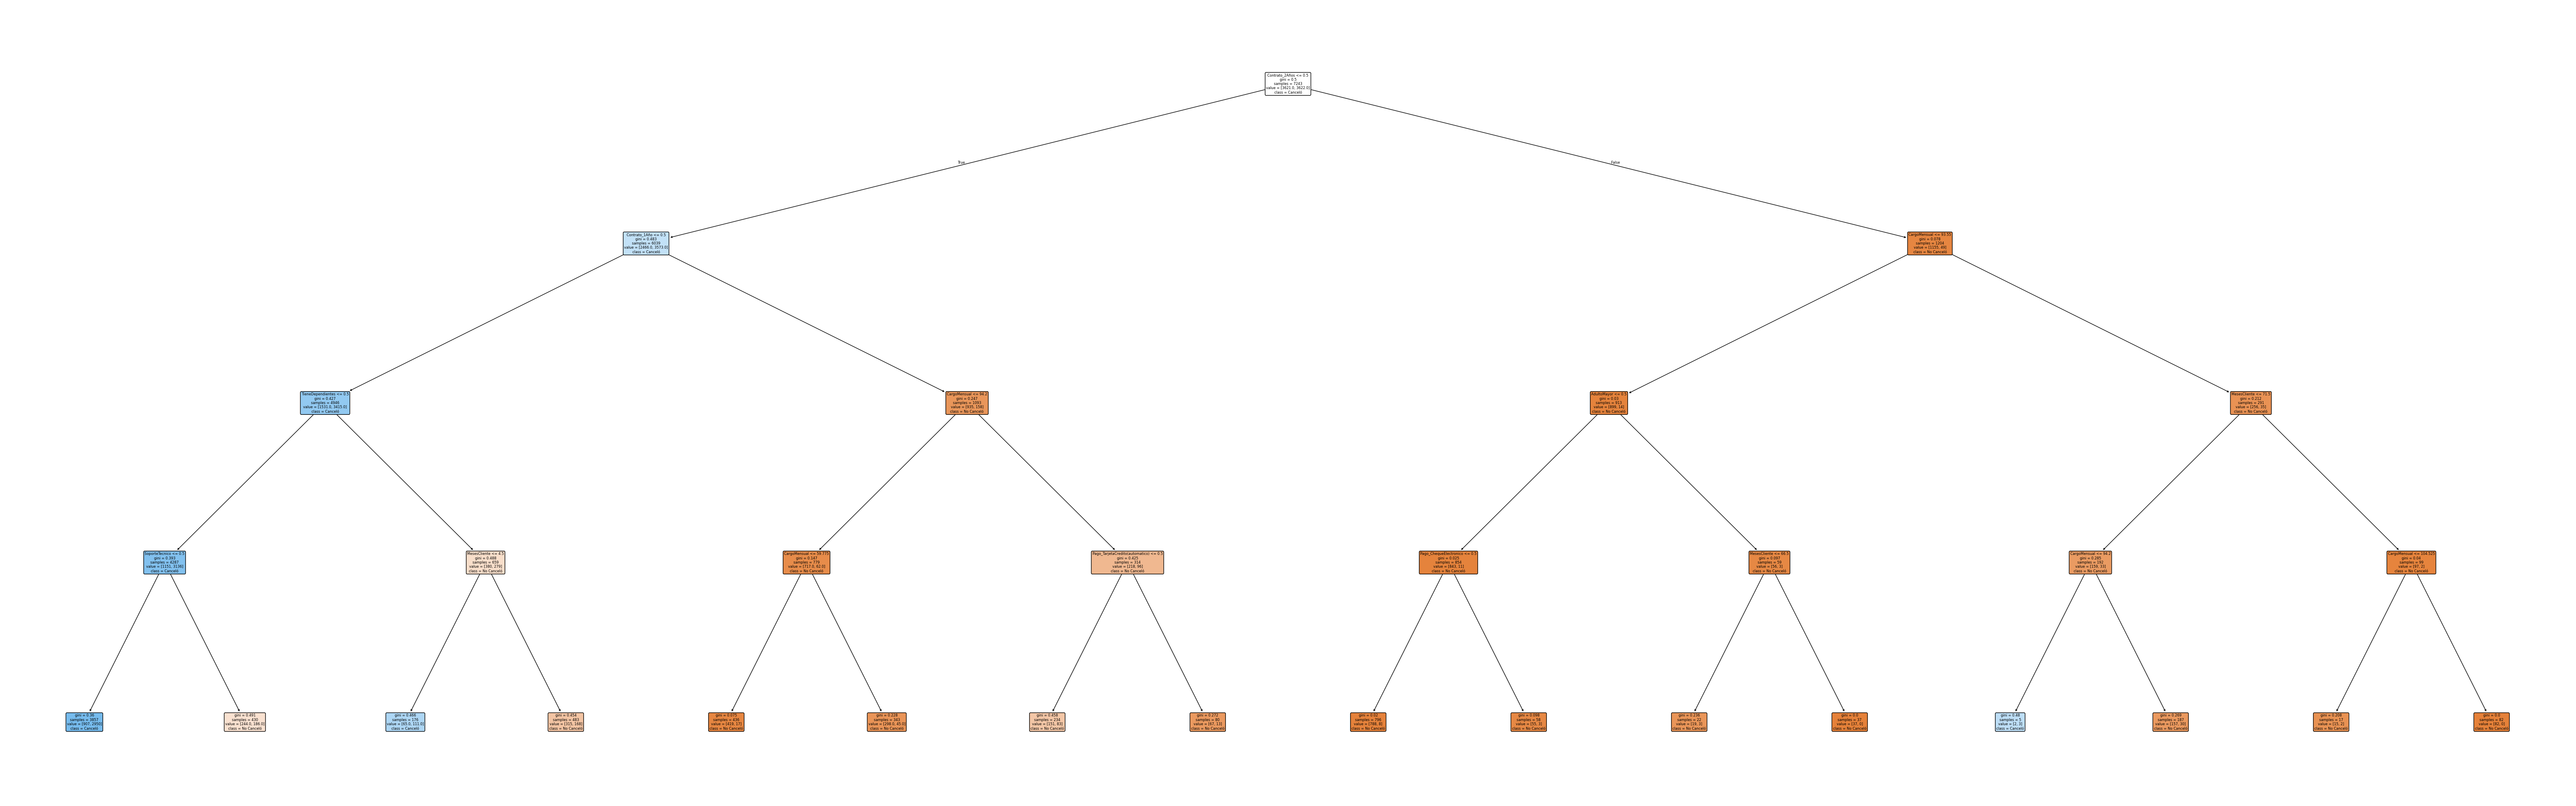

In [198]:
y_pred_arbol = modelo_arbol.predict(X_test)

print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred_arbol))

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_arbol))

print(f"Exactitud (Accuracy): {accuracy_score(y_test, y_pred_arbol):.4f}")


plt.figure(figsize=(80,25))
plot_tree(modelo_arbol,
          feature_names=X.columns,
          class_names=['No Canceló', 'Canceló'],
          filled=True,
          rounded=True,
          fontsize=6,
          max_depth=4)  # Limitar a profundidad 4
plt.show()


**Dado que los resultados que obtuvimos notamos que el modelo puede ser favorable, sin embargo, decidimos realizar una curva de validación para confirmar qué profundidad maximiza el rendimiento y obtener un mejor modelo**

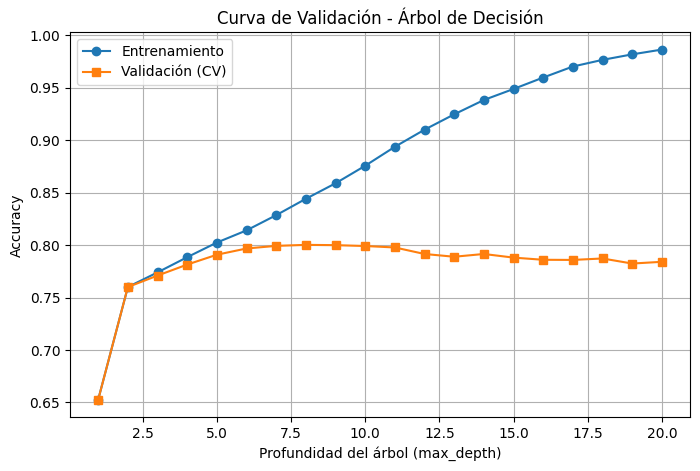

In [199]:
profundidades = range(1, 21)

train_scores = []
test_scores = []

for d in profundidades:
    modelo = DecisionTreeClassifier(max_depth=d, random_state=42)
    scores = cross_val_score(modelo, X_train, y_train, cv=5, scoring='accuracy')

    test_scores.append(scores.mean())

    modelo.fit(X_train, y_train)
    train_scores.append(modelo.score(X_train, y_train))

plt.figure(figsize=(8,5))
plt.plot(profundidades, train_scores, label="Entrenamiento", marker='o')
plt.plot(profundidades, test_scores, label="Validación (CV)", marker='s')
plt.xlabel("Profundidad del árbol (max_depth)")
plt.ylabel("Accuracy")
plt.title("Curva de Validación - Árbol de Decisión")
plt.legend()
plt.grid(True)
plt.show()


**En base al resultado de la curva de validación podemos notar que una profundidad de 10 puede tener mejor resultado para nuestro modelo, por lo que procedemos a aplicarlo**

In [200]:
modelo_arbol = DecisionTreeClassifier(
    criterion='gini',
    max_depth=10,     # profundidad de 10
    random_state=42
)
modelo_arbol.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, random_state=42)

In [201]:
modelo_arbol.score(X_train, y_train)

0.875604031478669

Matriz de Confusión:
[[1115  438]
 [ 193 1359]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.85      0.72      0.78      1553
           1       0.76      0.88      0.81      1552

    accuracy                           0.80      3105
   macro avg       0.80      0.80      0.80      3105
weighted avg       0.80      0.80      0.80      3105

Exactitud (Accuracy): 0.7968


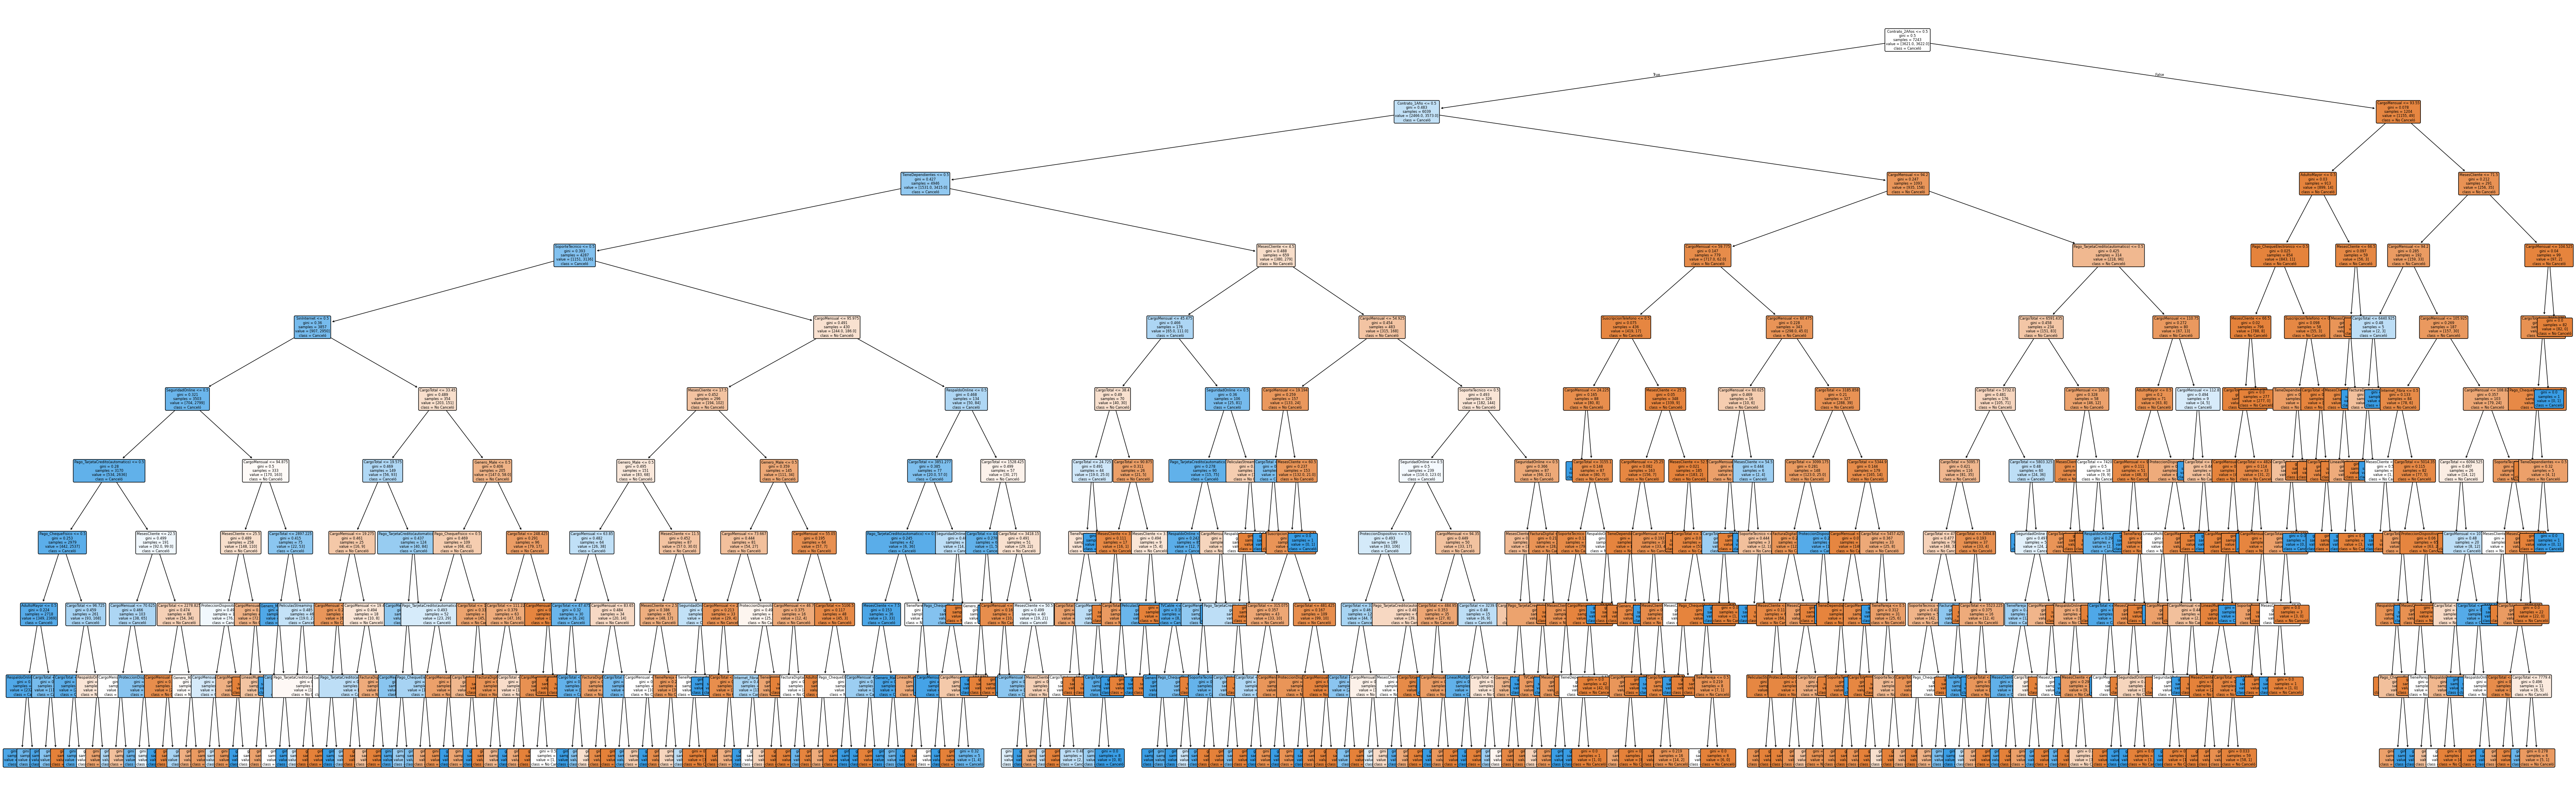

In [202]:
y_pred_arbol = modelo_arbol.predict(X_test)

print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred_arbol))

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_arbol))

print(f"Exactitud (Accuracy): {accuracy_score(y_test, y_pred_arbol):.4f}")


plt.figure(figsize=(80,25))
plot_tree(modelo_arbol,
          feature_names=X.columns,
          class_names=['No Canceló', 'Canceló'],
          filled=True,
          rounded=True,
          fontsize=6,
          max_depth=10)  # Limitar a profundidad 10
plt.show()

**Aplicando la mejora al modelo podemos notar que**
* **Accuracy: 0.78 -> 0.80**
* **Recall no evasion -> 0.71 → 0.72**
* **Recall evasion -> 0.85 → 0.88**

**Por lo que Podemos notar que el modelo captura mejor a los clientes que deciden evadir**

## Random Forest

**Ahora procedemos a crear un modelo de Random Forest**

In [203]:

modelo_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42
)

modelo_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=42)

In [204]:
modelo_rf.score(X_train, y_train)

0.89134336600856

**Procedemos a evaluar el modelo**

In [205]:

modelo_rf.fit(X_train, y_train)

y_pred_rf = modelo_rf.predict(X_test)

print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred_rf))

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_rf))

print("Exactitud (Accuracy): {:.4f}".format(accuracy_score(y_test, y_pred_rf)))


Matriz de Confusión:
[[1204  349]
 [ 179 1373]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.87      0.78      0.82      1553
           1       0.80      0.88      0.84      1552

    accuracy                           0.83      3105
   macro avg       0.83      0.83      0.83      3105
weighted avg       0.83      0.83      0.83      3105

Exactitud (Accuracy): 0.8300


**En base a esto, podemos notar que el modelo de Random Forest está rindiendo mejor que el Árbol de Decisión, ya que el Accuracy subió a 0.83 a diferencia del árbol de decisión que proporciono un 0.80, por igual podemos notar que el recall de la clase de evasión presento un 0.88, lo cual resulta de importancia ya que nos interesa es detectar bien a los clientes que deciden evadir**

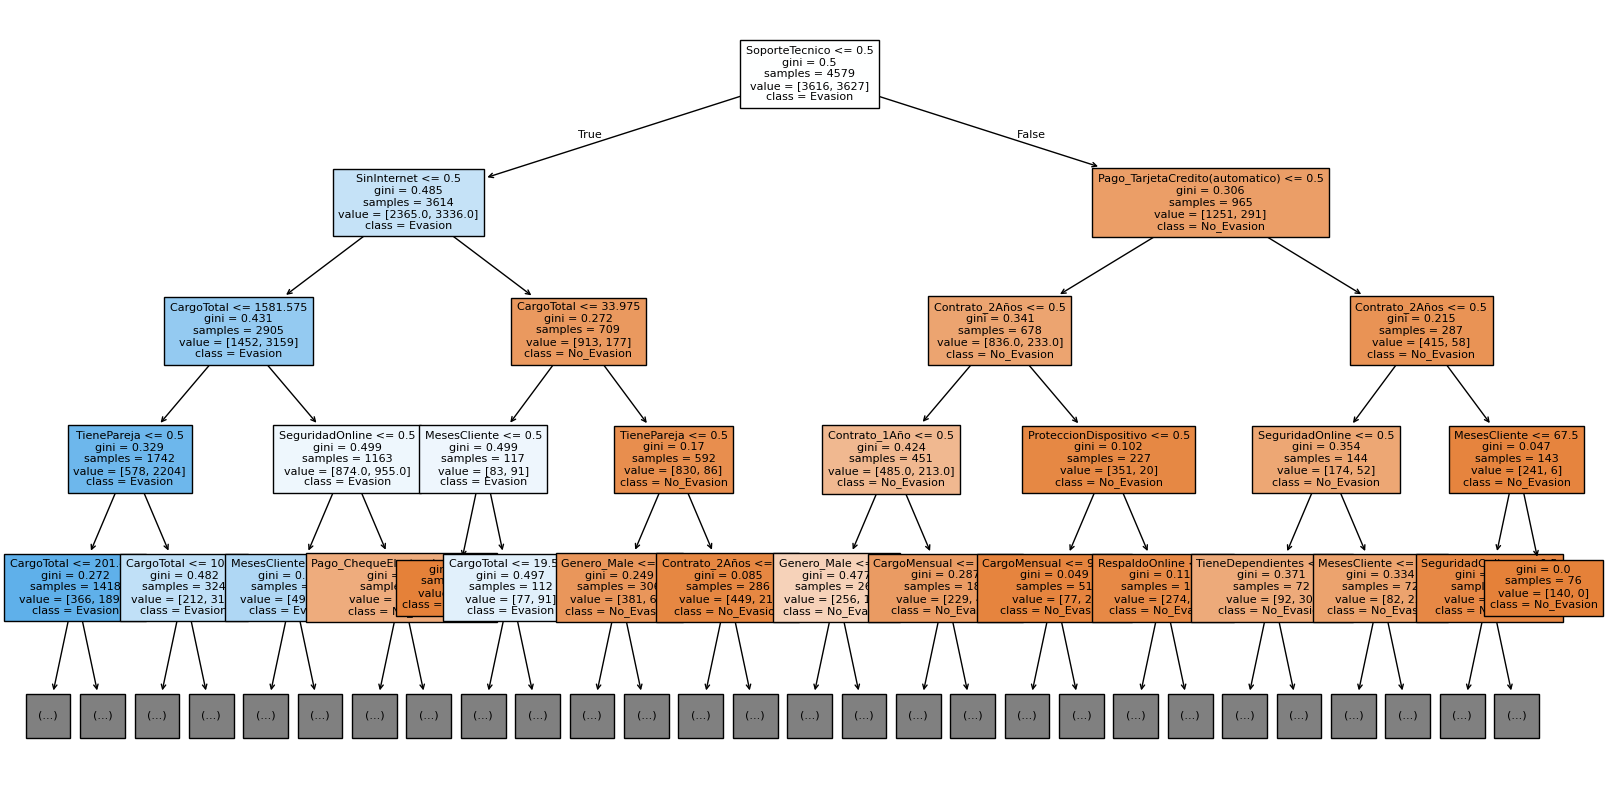

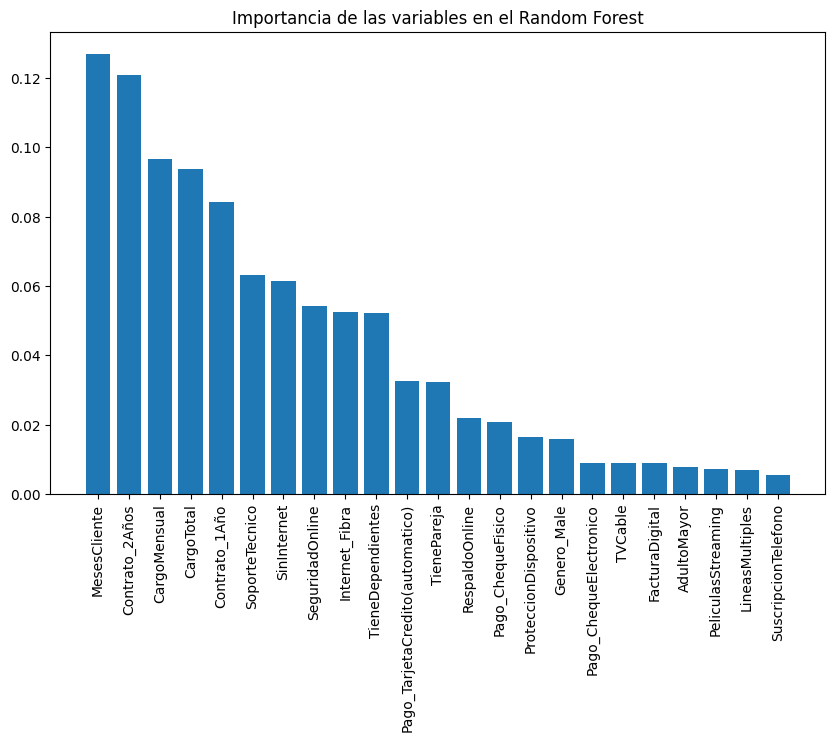

In [206]:

plt.figure(figsize=(20,10))
arbol_individual = modelo_rf.estimators_[0]
tree.plot_tree(arbol_individual,
               feature_names=X.columns,
               class_names=["No_Evasion","Evasion"],
               filled=True,
               max_depth=4,
               fontsize=8)
plt.show()

importances = modelo_rf.feature_importances_
indices = importances.argsort()[::-1]

plt.figure(figsize=(10,6))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), X.columns[indices], rotation=90)
plt.title("Importancia de las variables en el Random Forest")
plt.show()


**El modelo de Random Forest ya presenta buenos resultados, sin embargo deseamos optimizarlo buscando los mejores parámetros para poder tener mejor resultados y mejorar el modelo aun mas si es posible. Para esto haremos uso de GridSearchCV para probar distintos parámetros y obtener los mejores valores**

In [207]:

# Definimos parámetros
param_grid = {
    'n_estimators': [100, 200, 300],   # número de árboles
    'max_depth': [None, 10, 20],       # profundidad máxima
    'min_samples_split': [2, 5, 10],   # mínimo de muestras para dividir
    'min_samples_leaf': [1, 2, 4]      # mínimo de muestras en una hoja
}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

grid_search.fit(X_train, y_train)

print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

print("Mejor exactitud en validación cruzada:")
print(grid_search.best_score_)


Fitting 3 folds for each of 81 candidates, totalling 243 fits
Mejores hiperparámetros encontrados:
{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Mejor exactitud en validación cruzada:
0.836669519818542


**Tras obtener los mejores parámetros lo aplicamos a nuestro modelo de Random Forest**

In [208]:

# Usamos los datos encontrado por GridSearchCV
mejor_rf = grid_search.best_estimator_


y_pred = mejor_rf.predict(X_test)

print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))


accuracy = accuracy_score(y_test, y_pred)
print(f"\nExactitud (Accuracy): {accuracy:.4f}")


Matriz de Confusión:
[[1269  284]
 [ 201 1351]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1553
           1       0.83      0.87      0.85      1552

    accuracy                           0.84      3105
   macro avg       0.84      0.84      0.84      3105
weighted avg       0.84      0.84      0.84      3105


Exactitud (Accuracy): 0.8438


**Visualizamos la matriz de cofusion**

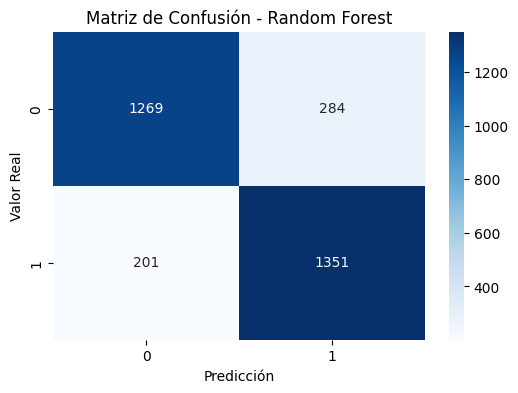

In [209]:

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.title("Matriz de Confusión - Random Forest")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.show()


## KNN

### Normalizacion de datos

**Continuamos ahora realizando un modelo de KNN, sin embargo para poder realizarlo es necesario normalizar los datos, la normalización nos ayuda a asegurar que todas las variables aporten de forma comparable en el cálculo de distancias y en modelos que usan optimización por lo que no se verán sesgados por la magnitud de las variables.**

In [210]:
# Normalizamos con MinMaxScaler
normalizacion = MinMaxScaler()
X_train_normalizado = normalizacion.fit_transform(X_train)
X_test_normalizado = normalizacion.transform(X_test)


In [211]:
pd.DataFrame(X_train_normalizado)

0    1    2         3    4    5    6    7    8    9   ...        13  \
0     0.0  1.0  1.0  0.222222  1.0  0.0  0.0  0.0  0.0  0.0  ...  0.012955   
1     0.0  0.0  0.0  0.027778  1.0  1.0  0.0  0.0  0.0  0.0  ...  0.752264   
2     0.0  0.0  0.0  0.083333  1.0  0.0  1.0  0.0  1.0  1.0  ...  0.600399   
3     0.0  1.0  0.0  0.416667  1.0  1.0  0.0  0.0  0.0  0.0  ...  0.663677   
4     0.0  0.0  0.0  0.097222  1.0  0.0  0.0  0.0  0.0  0.0  ...  0.608056   
...   ...  ...  ...       ...  ...  ...  ...  ...  ...  ...  ...       ...   
7238  0.0  0.0  0.0  0.569444  1.0  0.0  0.0  0.0  0.0  0.0  ...  0.013453   
7239  0.0  0.0  0.0  0.500000  1.0  0.0  0.0  0.0  1.0  0.0  ...  0.608929   
7240  0.0  0.0  0.0  0.013889  1.0  0.0  0.0  0.0  0.0  0.0  ...  0.018435   
7241  1.0  0.0  0.0  0.361111  1.0  0.0  1.0  0.0  0.0  0.0  ...  0.671649   
7242  1.0  0.0  0.0  0.291667  1.0  0.0  0.0  0.0  1.0  0.0  ...  0.415047   

            14   15   16   17   18   19   20   21   22  
0     0.034771  0.0  1.0  0.0  1.0  0.0  0.0  1.0  0.0  
1     0.022648  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2     0.055728  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  
3     0.302596  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  
4     0.060372  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...        ...  ...  ...  ...  ...  ...  ...  ...  ...  
7238  0.093048  0.0  1.0  1.0  0.0  0.0  0.0  1.0  0.0  
7239  0.322979  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
7240  0.002335  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  
7241  0.252945  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  
7242  0.142538  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  

[7243 rows x 23 columns]

### Creando KNN

In [212]:
knn = KNeighborsClassifier()

In [213]:
knn.fit(X_train_normalizado, y_train)

KNeighborsClassifier()

In [214]:
X_test_normalizado = normalizacion.transform(X_test)

In [215]:
knn.score(X_test_normalizado, y_test)

0.8054750402576489

**Tras crear el modelo procedemos a evaluarlo**

In [216]:
y_pred_knn = knn.predict(X_test_normalizado)

print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred_knn))

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_knn))

print("\nExactitud (Accuracy): {:.4f}".format(accuracy_score(y_test, y_pred_knn)))


Matriz de Confusión:
[[1127  426]
 [ 178 1374]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.86      0.73      0.79      1553
           1       0.76      0.89      0.82      1552

    accuracy                           0.81      3105
   macro avg       0.81      0.81      0.80      3105
weighted avg       0.81      0.81      0.80      3105


Exactitud (Accuracy): 0.8055


**Con estos datos podemos notar que nuestro modelo KNN acierta en aproximadamente el 80.5% de las predicciones en nuestro conjunto de pruebas, aunque este resultado se encuentra ligeramente por debajo de los resultados que obtuvimos con Random Forest, sin embargo, es mejor que el modelo de árbol de decisión.**

**En base a lo anterior deseamos verificar los parámetros que serían óptimos para nuestro modelo y poder los mejores valores**


In [217]:
param_grid = {
    'n_neighbors': range(3, 21),   # probamos k de 3 a 20
    'weights': ['uniform', 'distance'],  # peso igual o según distancia
    'metric': ['euclidean', 'manhattan'] # métricas de distancia
}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)


grid_search.fit(X_train_normalizado, y_train)

print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

print("\nMejor exactitud en validación cruzada:")
print(grid_search.best_score_)

Mejores hiperparámetros encontrados:
{'metric': 'euclidean', 'n_neighbors': 14, 'weights': 'uniform'}

Mejor exactitud en validación cruzada:
0.8129205129085024


**Tras obtener los mejores parámetros procedemos a evaluar nuevamente nuestro modelo de KNN con estos resultados**

In [218]:
mejor_knn = grid_search.best_estimator_

y_pred_knn = mejor_knn.predict(X_test_normalizado)


print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred_knn))

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_knn))

print("\nExactitud (Accuracy):", accuracy_score(y_test, y_pred_knn))


Matriz de Confusión:
[[1134  419]
 [ 162 1390]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.88      0.73      0.80      1553
           1       0.77      0.90      0.83      1552

    accuracy                           0.81      3105
   macro avg       0.82      0.81      0.81      3105
weighted avg       0.82      0.81      0.81      3105


Exactitud (Accuracy): 0.8128824476650564


**Graficamos la matriz de confusión**

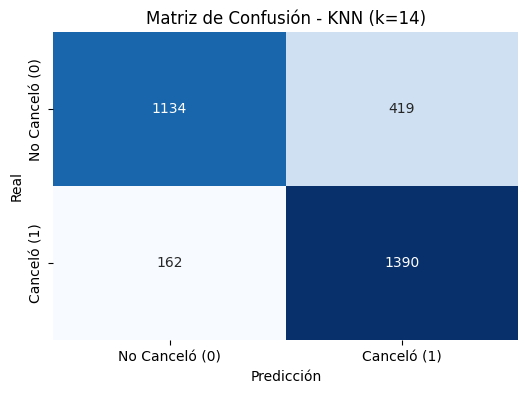

In [219]:

cm = confusion_matrix(y_test, y_pred_knn)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Canceló (0)", "Canceló (1)"],
            yticklabels=["No Canceló (0)", "Canceló (1)"])

plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - KNN (k=14)")
plt.show()


## Evaluación de los Modelos

In [220]:

resultados = {}

modelos = {
    "Árbol de Decisión": modelo_arbol,
    "Random Forest": mejor_rf,
    "KNN": mejor_knn
}

# Evaluamos cada modelo
for nombre, modelo in modelos.items():
    if nombre == "KNN":
        y_pred = modelo.predict(X_test_normalizado)
    else:
        y_pred = modelo.predict(X_test)

    exactitud = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    matriz = confusion_matrix(y_test, y_pred)

    resultados[nombre] = {
        "Exactitud": exactitud,
        "Precisión": precision,
        "Recall": recall,
        "F1-score": f1,
        "Matriz de Confusión": matriz
    }

df_resultados = pd.DataFrame({
    modelo: {
        "Exactitud": resultados[modelo]["Exactitud"],
        "Precisión": resultados[modelo]["Precisión"],
        "Recall": resultados[modelo]["Recall"],
        "F1-score": resultados[modelo]["F1-score"]
    }
    for modelo in resultados
}).T

print("Resultados comparativos de métricas:")
print(df_resultados)

print("\nMatrices de Confusión por modelo:")
for modelo in resultados:
    print(f"\n{modelo}:")
    print(resultados[modelo]["Matriz de Confusión"])


Resultados comparativos de métricas:
                   Exactitud  Precisión    Recall  F1-score
Árbol de Decisión   0.796779    0.75626  0.875644  0.811586
Random Forest       0.843800    0.82630  0.870490  0.847819
KNN                 0.812882    0.76838  0.895619  0.827135

Matrices de Confusión por modelo:

Árbol de Decisión:
[[1115  438]
 [ 193 1359]]

Random Forest:
[[1269  284]
 [ 201 1351]]

KNN:
[[1134  419]
 [ 162 1390]]


# 4. Interpretación y Conclusiones

## Importancia de las Variables

**Procedemos a va a realiza el análisis de las variables más relevantes para la predicción de la cancelación en cada uno de los modelos creados**

                           Variable  Importancia             Modelo
18                   Contrato_2Años     0.263625  Árbol de Decisión
17                    Contrato_1Año     0.230789  Árbol de Decisión
14                       CargoTotal     0.094335  Árbol de Decisión
13                     CargoMensual     0.088456  Árbol de Decisión
2                 TieneDependientes     0.048461  Árbol de Decisión
9                    SoporteTecnico     0.046579  Árbol de Decisión
6                   SeguridadOnline     0.040971  Árbol de Decisión
3                      MesesCliente     0.040262  Árbol de Decisión
16                      SinInternet     0.038589  Árbol de Decisión
19  Pago_TarjetaCredito(automatico)     0.027577  Árbol de Decisión
21                Pago_ChequeFisico     0.013999  Árbol de Decisión
7                    RespaldoOnline     0.011372  Árbol de Decisión
22                      Genero_Male     0.010917  Árbol de Decisión
8             ProteccionDispositivo     0.008103

/tmp/ipython-input-670176016.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_importancia_arbol, x="Importancia", y="Variable", palette="viridis")


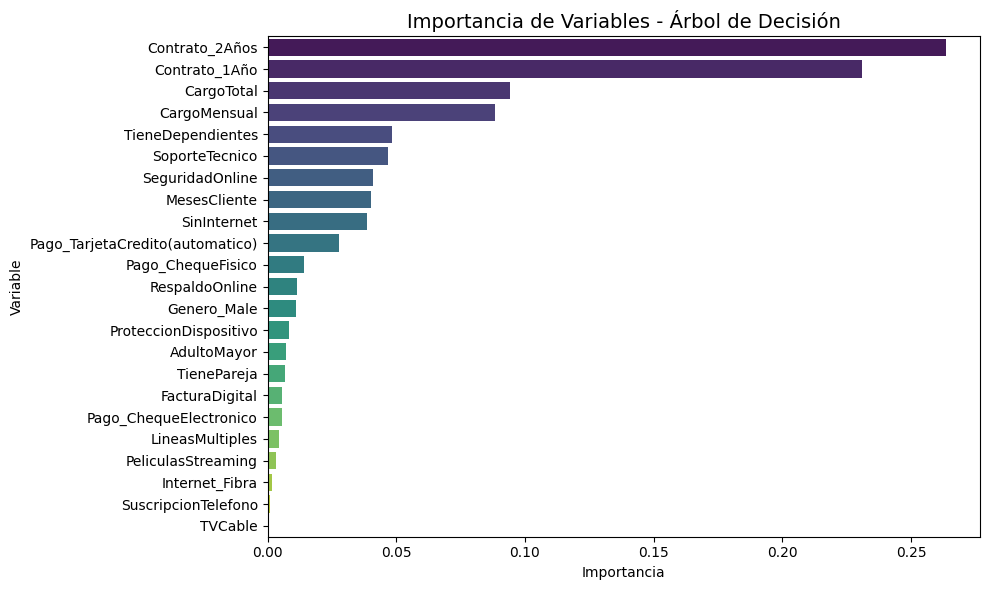

In [221]:
# Importancia de las variables en el Árbol de Decisión
importancias_arbol = modelo_arbol.feature_importances_

df_importancia_arbol = pd.DataFrame({
    'Variable': X_train.columns,
    'Importancia': importancias_arbol,
    'Modelo': 'Árbol de Decisión'
}).sort_values(by='Importancia', ascending=False)

print(df_importancia_arbol)

plt.figure(figsize=(10,6))
sns.barplot(data=df_importancia_arbol, x="Importancia", y="Variable", palette="viridis")
plt.title("Importancia de Variables - Árbol de Decisión", fontsize=14)
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

                           Variable  Importancia         Modelo
3                      MesesCliente     0.135495  Random Forest
13                     CargoMensual     0.130992  Random Forest
14                       CargoTotal     0.128711  Random Forest
18                   Contrato_2Años     0.086468  Random Forest
17                    Contrato_1Año     0.062929  Random Forest
9                    SoporteTecnico     0.052210  Random Forest
16                      SinInternet     0.046696  Random Forest
6                   SeguridadOnline     0.045262  Random Forest
15                   Internet_Fibra     0.041507  Random Forest
2                 TieneDependientes     0.039920  Random Forest
1                       TienePareja     0.029151  Random Forest
19  Pago_TarjetaCredito(automatico)     0.027034  Random Forest
21                Pago_ChequeFisico     0.022756  Random Forest
7                    RespaldoOnline     0.022503  Random Forest
22                      Genero_Male     

/tmp/ipython-input-1647534224.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_importancia_rf.head(15), x="Importancia", y="Variable", palette="viridis")


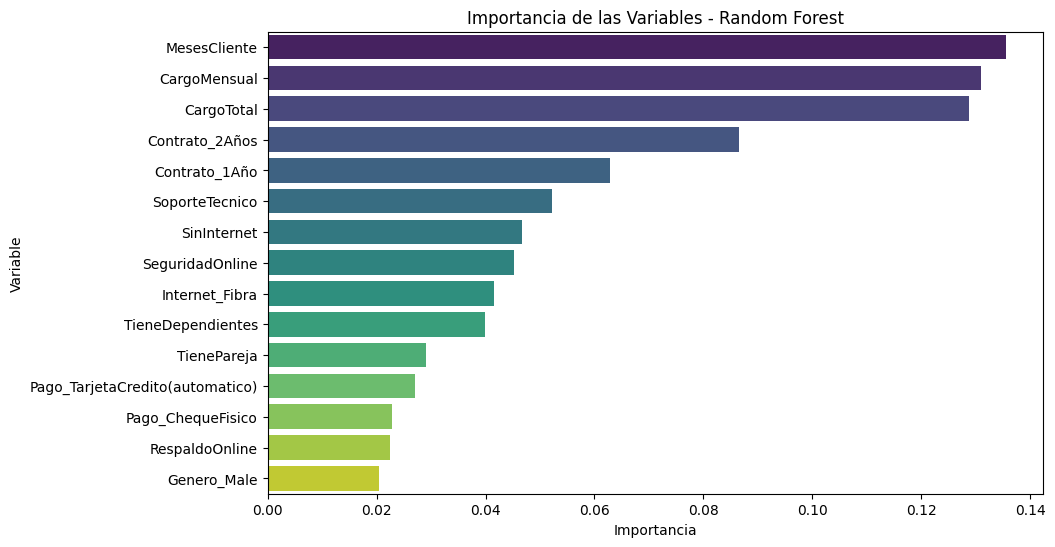

In [222]:

# Importancia de variables en Random Forest
importancias = mejor_rf.feature_importances_

df_importancia_rf = pd.DataFrame({
    "Variable": X_train.columns,
    "Importancia": importancias,
    'Modelo': 'Random Forest'
}).sort_values(by="Importancia", ascending=False)

print(df_importancia_rf.head(15))

plt.figure(figsize=(10,6))
sns.barplot(data=df_importancia_rf.head(15), x="Importancia", y="Variable", palette="viridis")
plt.title("Importancia de las Variables - Random Forest")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.show()


                           Variable  Importancia Modelo
16                      SinInternet     0.012947    KNN
21                Pago_ChequeFisico     0.011530    KNN
6                   SeguridadOnline     0.011465    KNN
15                   Internet_Fibra     0.010853    KNN
17                    Contrato_1Año     0.009726    KNN
9                    SoporteTecnico     0.009662    KNN
18                   Contrato_2Años     0.009662    KNN
3                      MesesCliente     0.009308    KNN
7                    RespaldoOnline     0.008696    KNN
19  Pago_TarjetaCredito(automatico)     0.007118    KNN
14                       CargoTotal     0.006892    KNN
20           Pago_ChequeElectronico     0.006892    KNN
12                   FacturaDigital     0.006506    KNN
13                     CargoMensual     0.005733    KNN
22                      Genero_Male     0.005314    KNN


/tmp/ipython-input-2832041172.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_importancia_knn.head(15), x="Importancia", y="Variable", palette="mako")


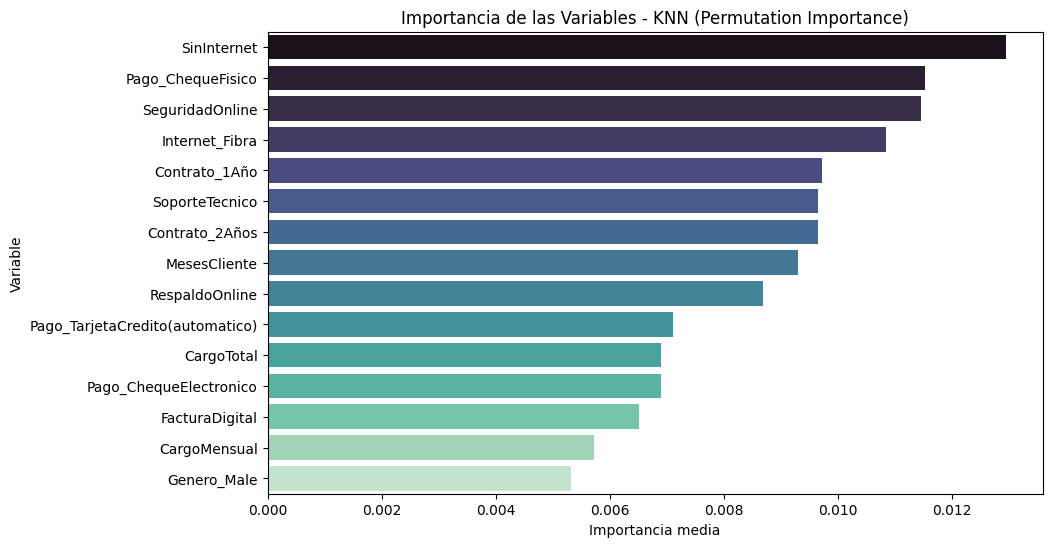

In [223]:
# Importancia por permutación en el modelo KNN
resultado_perm = permutation_importance(mejor_knn, X_test_normalizado, y_test, n_repeats=10, random_state=42)

df_importancia_knn = pd.DataFrame({
    "Variable": X_train.columns,
    "Importancia": resultado_perm.importances_mean,
     'Modelo': 'KNN'
}).sort_values(by="Importancia", ascending=False)


print(df_importancia_knn.head(15))

plt.figure(figsize=(10,6))
sns.barplot(data=df_importancia_knn.head(15), x="Importancia", y="Variable", palette="mako")
plt.title("Importancia de las Variables - KNN (Permutation Importance)")
plt.xlabel("Importancia media")
plt.ylabel("Variable")
plt.show()


**Teniendo ya los resultados de las variables mas relevantes realizamos ahora un grafico comparativo con los modelos que hemos realizado**

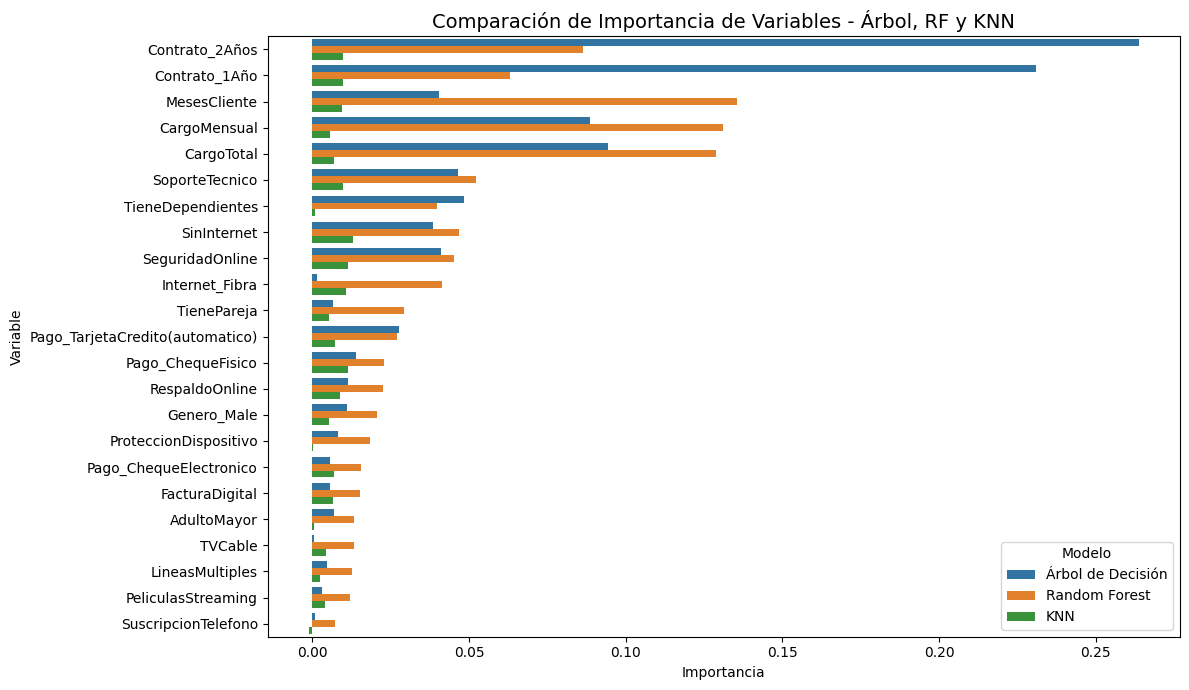

In [224]:
# Concatenamos todos los resultados
df_importancia_total = pd.concat([df_importancia_arbol, df_importancia_rf, df_importancia_knn])

# Ordenamos por importancia
df_importancia_total = df_importancia_total.sort_values(by="Importancia", ascending=False)

plt.figure(figsize=(12,7))
sns.barplot(data=df_importancia_total, x="Importancia", y="Variable", hue="Modelo")
plt.title("Comparación de Importancia de Variables - Árbol, RF y KNN", fontsize=14)
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.legend(title="Modelo")
plt.tight_layout()
plt.show()


In [241]:
with open('modelo_arbol.pkl','wb') as archivo:
  pickle.dump(modelo_arbol,archivo)

In [243]:
with open('modelo_KNN.pkl','wb') as archivo:
  pickle.dump(mejor_knn,archivo)

In [244]:
with open('modelo_champion.pkl','wb') as archivo:
  pickle.dump(mejor_rf,archivo)

# Conclusión

## 1. Evaluación de Modelos

Durante nuestro análisis se realizaron y evaluaron tres modelos de Machine Learning diferentes, los cuales fueron árbol de decisiones, Random Forest y KNN, obteniendo los siguientes resultados

| Modelo            | Exactitud | Precisión | Recall    | F1-score  |                                                                                                           |
| ----------------- | --------- | --------- | --------- | --------- | -------------------------------------------------------------------------------------------------------------------------- |
| Árbol de Decisión | **0.797** | 0.756     | 0.876     | 0.812     |                                    |
| Random Forest     | **0.844** | **0.826** | 0.870     | **0.848** |                        |
| KNN               | 0.813     | 0.768     | **0.896** | 0.827     |



En base a los resultados podemos definir lo siguiente:

* Random Forest, este modelo obtuvo un mejor desempeño general de los 3 modelos que  fueron evaluados así como el modelo no mostro indicios fuertes de overfitting


## 2. Factores Clave en la Cancelación

Por igual se analizaron las variables que influyen más en la cancelación obteniendo los siguientes resultados

### **Random Forest – Variables más influyentes**

1. CargoMensual
2. CargoTotal
3. Contrato_2Años
4. Contrato_1Año
5. SoporteTecnico
6. SinInternet

En base a las variables mas influyentes podemos notar que los clientes con poca antigüedad o meses con el servicio y clientes con cargos mensuales altos presentan un mayor riesgo de evasión así mismo clientes que no cuentan con algunos servicios adicionales como SoporteTecnico, ya que el contar con servicios adicionales aumenta la permanencia

### KNN – Variables más influyentes

1. SinInternet
2. Pago_ChequeFisico
3. SeguridadOnline
4. Internet_Fibra
5. Contrato_1Año

A diferencia de Random Forest, en KNN podemos notar que las variables de importancia cambian, ya que en KNN podemos notar que el contar o no con internet y el tipo de pago son variables que marcan la diferencia entre los clientes que deciden quedarse o evadir.

Así como por igual podemos notar que los cliente con fibra óptica y aquellos que tienen un tipo de pago físico son mas propensos a evadir por lo que resulta de importancia enfocarse en crear soluciones para mejorar estos puntos.


## 3. Estrategias de Retención

* En base a los resultados de las variables de importancia que los modelos mostraron podemos definir algunas propuestas que puedan aplicarse para evitar que los clientes decidan evadir. Algunas de las propuestas pueden ser las siguientes.

* Con el fin de reducir la evasión en clientes nuevos se pueden aplicar programas de beneficios para clientes con menos de 12 meses de antigüedad, de esta forma se motiva al cliente para continuar con el servicio y pueda llegar al año, logrando de esta forma aumentar la permanencia.

* Precios flexibles, conociendo que los costos mensuales son un factor de evasión se pueden crear planes o paquetes personalizados para aquellos clientes que tengan cargos altos, asi como por igual se puede incentivar a los clientes proporcionándoles descuentos o promociones al cumplir cierta cantidad de tiempo con el servicio como 1 año o 2 años.

* Por igual se pueden realizar promociones o beneficios especiales para aquellos clientes que contraten por 1 0 2 años, de esta forma de incentiva a los clientes a obtener contratos de mayor duración y reforzar su permanencia.

* Servicios adiciones, sabemos que los servicios adicionales como Seguridad Online y Soporte técnico son factores que incluyen en si los clientes deciden permanecer o evadir, por lo cual se pueden crear paquetes o planes que incluyan estos servicios, así como por igual el proporcionarles a los clientes una prueba gratuita por determinado tiempo puede reforzar la permanencia al probar los beneficios de los servicios adicionales.

* Pagos automáticos, se requiere dar más promoción a que los clientes utilicen formas de pago automáticas para realizar sus pagos de servicio, promoviendo sus beneficios o aplicando descuentos o promociones a los clientes que usen estos métodos de pago, de esta forma se busca que los clientes con otras formas de pago cambien a pagos automáticos reforzando su permanencia.


## 4. Conclusiones Finales

Con ayuda del modelo Random Forest pudimos identificar claramente que la antigüedad, el precio del servicio asi como el tipo de contrato que los clientes tienen, son algunos de los principales factores determinantes de la evasión

Por otro lado con el modelo KNN nos ayudo a confirmar que las variables relacionadas con el tipo de internet y el método de pago también son factores importantes de la evasión

* Es por ello que nuestras estrategias se resumen en lo siguiente:
* Retener a clientes nuevos
* Revisión o flexibilizar los precios
* Promocionar contratos de largo plazo
* Incentivar al uso de pagos automáticos
* Promover los servicios adicionales como soporte técnico y seguridad.
